In [235]:
import pandas as pd
import geopandas as gpd
import numpy as np

from bokeh.plotting import figure, show, save
from bokeh.models import GeoJSONDataSource, ColumnDataSource, HoverTool
from bokeh.io import export_png
import matplotlib.pyplot as plt

import shapely

import sys

sys.path.append("../")

from Code.helper_functions import initial_loading
from Code.loading_data import load_api_data

### Errors on loading API data
It appeared that there were some problems regarding the loading of the data using the API. The connection got actively refused. After some testing a backup plan using a try-except clausule was implemented to prevent this from happening again

In [ ]:
load_api_data(prnt=True)

In [ ]:
df_api = pd.read_csv('../Data/afval_cluster.csv', delimiter=';')
df_api = df_api[df_api['cluster_datum_einde_cluster'].isna()]
df_api = df_api[['cluster_geometrie', 'cluster_fractie_aantal', 'cluster_fractie_volume', 'bag_adres_openbare_ruimte_naam', 'gbd_buurt_code']]
df_api['cluster_x'] = df_api['cluster_geometrie'].apply(lambda x: x.split('(')[1].split(' ')[0])
df_api['cluster_y'] = df_api['cluster_geometrie'].apply(lambda x: x.split()[1][:-1])
df_api = df_api.drop(['cluster_geometrie'], axis=1).rename(columns={'cluster_fractie_aantal':'aantal_per_fractie', 'cluster_fractie_volume':'volume_per_fractie', 'bag_adres_openbare_ruimte_naam':'street_name', 'gbd_buurt_code':'buurt'})

### Reassambling the score and penalty function
There was some bad coding going on in terms of the score and penalty function. There was also new reassignment of the normalization factor. An optional parameter to print all factors instead of the total penalties was also added

In [3]:
df_zo = pd.read_csv('../Results/20200510 - cluster optimization/hillclimber_best_config20200509-1228.csv')
all_households, rel_poi_df, joined, df_afstandn2 = initial_loading()

Do you want to use addresses instead of clusters?True
What stadsdeel do you want to make as a subsection(optional parameter)?
What is the maximum amount of containers in a cluster that is considered to be useful?8
Where to get db files(local/online)?local
DB relation POIs loaded


..\Code\loading_data.py:342: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  verblijfsobjecten['bag'] = verblijfsobjecten['split'].apply(lambda x: x[3])\
..\Code\loading_data.py:361: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['ligtin_bag_pnd_identificatie'] = \
..\Code\loading_data.py:369: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

distance matrix loaded
API data loaded
Table all households created
API and DB joined
containers per cluster determined


In [10]:
from Code.helper_functions import add_shortest_distances_to_all_households, analyze_candidate_solution
from Code.loading_data import create_aansluitingen

joined_cluster_distance = joined.set_index('s1_afv_nodes')\
    .join(df_afstandn2.set_index('van_s1_afv_nodes')).reset_index()\
    .rename(columns={'index': 'van_s1_afv_nodes'})

good_result = \
    add_shortest_distances_to_all_households(all_households,
                                             joined_cluster_distance,
                                             use_count=True)

aansluitingen = create_aansluitingen(good_result, joined_cluster_distance, use_count=True)

joined_cluster_distance, good_result_rich, aansluitingen,avg_distance, penalties = analyze_candidate_solution(joined, all_households, rel_poi_df, df_afstandn2, clean=True, use_count=True, return_all=True)

Average distance is : 138.07341312575804
Penalties are: [17.219834894699666, 35.32755966571079, 8.5595477517726, 7.424319847366339, 6.489463451225177, 11.635322254340808, 6.17924141829147, 8.689642332039632, 4.885983876726055, 1.9163206880799102]


### Optimization of other fractions in places where garbage is collected from the curbs
As nearly half of the city uses curbstone rest garbage collection, these can't just be excluded. Moreover, it also prevents dumping of undeseriable containers to these areas. The optional parameter clean has to be set to False for use. Its impact on the score function is to be determined further

In [ ]:
temp = good_result[good_result['uses_container'] == False]
# temp['rest_afstand'] = 9
# temp['poi_rest'] = 9
# good_result[good_result['uses_container']== False]['rest_afstand'] = 10
# good_result[good_result['uses_container'] == False]['poi_rest'] = 10
# good_result = good_result[good_result['uses_container'] == True]
# good_result = good_result.append(temp)
good_result.loc[~good_result['uses_container'], 'rest_afstand'] = np.nan
good_result.loc[~good_result['uses_container'], 'poi_rest'] = np.nan
good_result

In [11]:
joined_cluster_distance = joined.set_index('s1_afv_nodes')\
    .join(df_afstandn2.set_index('van_s1_afv_nodes')).reset_index()\
    .rename(columns={'index': 'van_s1_afv_nodes'})

good_result = \
    add_shortest_distances_to_all_households(all_households,
                                             joined_cluster_distance,
                                             use_count=True)

aansluitingen = create_aansluitingen(good_result, joined_cluster_distance, use_count=True)

joined_cluster_distance, good_result_rich, aansluitingen,avg_distance, penalties = analyze_candidate_solution(joined, all_households, rel_poi_df, df_afstandn2, clean=False, use_count=True, return_all=True)

Average distance is : 146.19040921349318
Penalties are: [13.986307090752906, 28.69377675645507, 9.378843150706075, 7.499677129681308, 7.517156350302604, 11.778384058219553, 6.732492989613896, 8.73765968127664, 4.993827792493072, 1.928099773320404]


### Plotting of distances and penalties
As optimization of just one of the parameters is possible within reasonable limits, the search arises for a way to compare these. One of the mentioned options was to optimize on one parameter, and hopefully find some point that is ideal. As the normal distance doesn't show anything, the best distance should be extracted

In [313]:
def plot_optimization(filename):
    df_plot1 = pd.read_csv(filename)
    df_plot1['diff'] = df_plot1['penalties'] - df_plot1['best']
    # df_plot1['total'] = df_plot1['avg_distance'] + df_plot1['penalties']
    df_plot1['best_dist'] = df_plot1[df_plot1['diff'] < 0]['avg_distance']
    df_plot1['best_dist'] = df_plot1['best_dist'].fillna(method='ffill')
    ax = df_plot1['best_dist'].plot(color='orange')
    ax.set_ylabel('average walking distance(meters)', color='orange')
    ax = df_plot1['best'].plot(color='blue', secondary_y=True)
    ax.set_ylabel('penalty score', color='blue')
    
    return ax

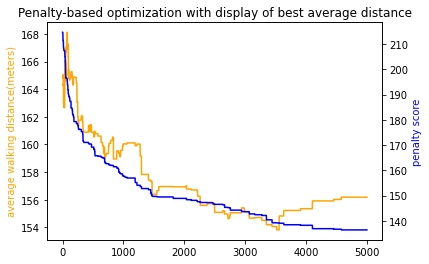

In [314]:
fig1 = plot_optimization('../Results/hillclimber2020-05-05-21.csv')
fig1.set_title('Penalty-based optimization with display of best average distance')
fig1.figure.savefig('Total.pdf')

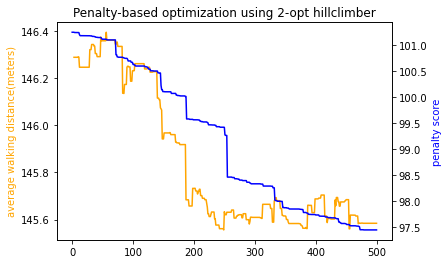

In [317]:
fig1 = plot_optimization('hillclimber20200521-1755.csv')
fig1.set_title('Penalty-based optimization using 2-opt hillclimber')
fig1.figure.savefig('2opt.pdf')

In [ ]:
plot_optimization('../Results/20200510 - cluster optimization/hillclimber20200510-1050.csv')

In [ ]:
plot_optimization('../Results/20200510 - cluster optimization/hillclimber20200512-0813.csv')

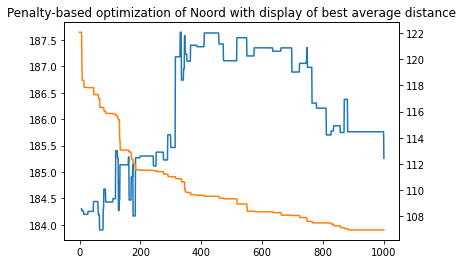

In [121]:
fig = plot_optimization('hillclimber20200516-2253.csv')
fig.set_title('Penalty-based optimization of Noord with display of best average distance')
fig.figure.savefig('noord.pdf')

It appears that an optimization approach where one of the parameters is chosen and constraints are set on the detoriation of the other may be an appropriate way to go. 

### Weight factors based on the amount of containers per fraction
The summation of the penalties and walking distances for the different fractions is hard to make, as some kind of weighing needs to be applied. One of the new approaches would be to determine these weights based on the amount of containers that is present, as this would probably correlate with the amount of garbage produced and the relative importance of the different fractions.

In [ ]:
joined_clean = joined[joined['totaal'] < 9]
temp = joined_clean[['rest', 'plastic', 'papier', 'glas', 'textiel', 'totaal']].sum()
temp

Based on these numbers the weights would be assigned the following way: Rest(0.61458), Plastic(0.088776), Papier(0.15774), Glas(0.11350) and Textiel(0.025397). This will be set as the default value for the penalties.

### Preventing the extra placement of Rest containers in light grey areas
As there are certain areas where restafval is picked up, it doesn't make sense to place extra rest containers there. It should be set as a hard constraint that this is not possible, to prevent certain dumping of containers in these areas. The first snippet of code is added to the loading phases to keep track of the possibilities for each cluster to add rest containers. The constraint that move_rest has to be true is added to the optimization algorithms

In [ ]:
from Code.loading_data import load_geodata_containers, address_in_service_area
shapefile = load_geodata_containers()
joined['move_rest'] = joined.apply(lambda row: address_in_service_area(row['cluster_x'], row['cluster_y'], polygon_list=shapefile), axis=1)
# joined[~joined['move_rest']][['rest', 'plastic', 'papier', 'glas', 'textiel', 'totaal']].sum()

In [ ]:
import random
r = joined
mod_max = 5

fractions = ['rest', 'plastic', 'papier', 'glas', 'textiel']
no_modifications = random.randint(1, mod_max)
#         print(no_modifications)
for j in range(no_modifications):
    valid = False
    while not valid:
        location_a = random.randint(0, r.shape[0]-1)
        fraction_a = random.choice(fractions)
        location_b = random.randint(0, r.shape[0]-1)
        fraction_b = random.choice(fractions)
        print(location_a, fraction_a, location_b, fraction_b, r.at[location_a, 'move_rest'])

        if int(r.at[location_a, fraction_b]) > 0 and \
                int(r.at[location_b, fraction_a]) > 0 and \
                fraction_a != fraction_b and not (fraction_a == 'rest' and
                                                  ~r.at[location_a, 'move_rest']):

            r.at[location_a, fraction_a] = \
                int(r.at[location_a, fraction_a]) + 1
            r.at[location_a, fraction_b] = \
                int(r.at[location_a, fraction_b]) - 1
            r.at[location_b, fraction_a] = \
                int(r.at[location_b, fraction_a]) - 1
            r.at[location_b, fraction_b] = \
                int(r.at[location_b, fraction_b]) + 1

            valid = True

In [9]:
joined = joined.drop(['index', 'Unnamed: 0'], axis=1)
joined

,cluster_x,cluster_y,s1_afv_rel_nodes_poi,bk_afv_rel_nodes_poi,s1_afv_nodes,s1_afv_poi,mf_insert_datetime,mf_update_datetime,mf_row_hash,mf_deleted_ind,...,buurt,wijk,stadsdeel,rest,plastic,papier,glas,textiel,totaal,move_rest
0,112740,487843,403086.0,112740.024~487843.078~afval_cluster~112740.024...,886520.0,86962.0,2020-04-01 13:57:12,2020-04-01 13:57:12,eff913f6-7550-319a-c7ff-eef1e9957e69,False,...,F80b,F80,F,0,1,1,1,0,3,False
1,112973,485077,157994.0,112973.480~485077.400~afval_cluster~112973.480...,641281.0,2280.0,2020-04-01 13:57:12,2020-04-01 13:57:12,ae17c84f-a562-e8b1-b8ab-9cfab692be79,False,...,F84b,F84,F,2,0,0,0,0,2,True
2,113012,484958,236214.0,113011.560~484957.980~afval_cluster~113011.560...,719542.0,131802.0,2020-04-01 13:57:12,2020-04-01 13:57:12,f6ff7538-a0fe-41a3-e871-2d2238f982d2,False,...,F84b,F84,F,1,0,1,0,0,2,True
3,113044,485173,139319.0,113043.960~485172.926~afval_cluster~113043.960...,622599.0,159060.0,2020-04-01 13:57:12,2020-04-01 13:57:12,842d1ea8-2d83-af0c-7450-b73071e6f847,False,...,F84b,F84,F,2,0,0,0,0,2,True
4,113049,487544,173098.0,113048.719~487543.976~afval_cluster~113048.719...,656393.0,121427.0,2020-04-01 13:57:12,2020-04-01 13:57:12,ec58fd32-090e-5c71-1fd6-65aef5f13c4a,False,...,F80b,F80,F,0,1,1,1,0,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5461,129532,484419,21341.0,129531.501~484418.765~afval_cluster~129531.501...,504553.0,1568.0,2020-04-01 13:57:12,2020-04-01 13:57:12,05f27cbc-2155-2c07-2fe4-2ee458c837f8,False,...,M51b,M51,M,1,0,0,0,0,1,True
5462,129621,479867,271956.0,129620.723~479866.800~afval_cluster~129620.723...,755306.0,55484.0,2020-04-01 13:57:12,2020-04-01 13:57:12,cc430177-0415-98b3-8362-2f1d2a7205d3,False,...,T98a,T98,T,0,0,0,1,0,1,False
5463,129755,479991,15018.0,129754.839~479990.691~afval_cluster~129754.839...,498227.0,252.0,2020-04-01 13:57:12,2020-04-01 13:57:12,f05ceb3e-4071-c0a2-b54f-9e4bc29c2021,False,...,T98a,T98,T,0,1,1,1,1,4,False
5464,129798,479676,412206.0,129798.472~479676.098~afval_cluster~129798.472...,895643.0,89247.0,2020-04-01 13:57:12,2020-04-01 13:57:12,5b1a3b4d-d0b0-1485-6693-682f0b8717ff,False,...,T98a,T98,T,0,1,1,1,0,3,False


#### Replacement of the function for Gaussian distribution hillclimber

In [110]:
import random
from collections import Counter

def hillclimber_variable_mutations(df, x=1.9):
    """
    Hillclimb with variable mutation strategy.

    This function uses Gaussian distribution to determine the amount of
    clusters to randomly re-assign. This can be modified by changing the
    optional parameter x. Its default setting of 1.9 allows for a small change.
    It returns a modified version of the input dataframe with some changes
    according to the specified x.
    """
    df = df.fillna(0)
    df['p'] = np.random.normal(0, 1, size=df.shape[0])
    df_to_change = df[df['p'] > x]
    if df_to_change.shape[0] < 2:  # Nothing happens in this case
        return df, df_to_change.shape[0]
    df = df[df['p'] < x]
    
    print("Amount of clusters to change: " + str(df_to_change.shape[0]))
    
    # Create upper threshold for grey area clusters
    df_to_change['rest_threshold'] = df_to_change['rest']
    df_to_change.loc[df_to_change['move_rest'],'rest_threshold'] = 999
    print(df_to_change['rest_threshold'].value_counts())

    # Extract all fractions
    rest = int(df_to_change['rest'].sum()) * ['rest']
    plastic = int(df_to_change['plastic'].sum()) * ['plastic']
    papier = int(df_to_change['papier'].sum()) * ['papier']
    glas = int(df_to_change['glas'].sum()) * ['glas']
    textiel = int(df_to_change['textiel'].sum()) * ['textiel']
    fracties = rest + plastic + papier + glas + textiel
    
    # lose the old configurations
    df_to_change = df_to_change.drop(['rest', 'plastic', 'papier',
                                  'glas', 'textiel'], axis=1)
    
    df_to_change = df_to_change.sort_values(by='rest_threshold')
    
    # Check if the new solution is valid. If not, repeat
    valid = False
    while not valid:
        fracties = plastic + papier + glas + textiel
        random.shuffle(fracties)
        fractions_per_cluster = []
        start_pnt = 0
        to_change = True
        for i in range(df_to_change.shape[0]):
            if df_to_change.iloc[i]['rest_threshold'] > 0 and to_change:
                to_change = False
                fracties = fracties + rest
                random.shuffle(fracties)
            length = df_to_change['totaal'].iloc[i]
            fractions_per_cluster.append(fracties[start_pnt:start_pnt + length])
            start_pnt += length
        df_to_change['new_containers'] = fractions_per_cluster
        print(df_to_change[['rest_threshold', 'new_containers']].head())

    
        df_to_change['rest'], df_to_change['plastic'], df_to_change['papier'], \
            df_to_change['glas'], df_to_change['textiel'] = \
            zip(*df_to_change['new_containers'].apply(lambda x: count(x)))
        if df_to_change[(df_to_change['rest'] > df_to_change['rest_threshold']) & (df_to_change['rest_threshold'] < 999)].shape[0] == 0:
            valid=True
        else:
            print(df_to_change[(df_to_change['rest'] > df_to_change['rest_threshold']) & (df_to_change['rest_threshold'] < 999)][['rest', 'rest_threshold']])

    df = df.append(df_to_change, ignore_index=True)
    df = df.drop(['p', 'new_containers'], axis=1)
    return df, df_to_change.shape[0]

def count(lst):
    """
    Count occurence of fractions in list.

    This function is part of an apply relation. It takese as input a list of
    different fractions. It returns the occurence of all these fractions based
    on a predefined format to be included as columns in a pandas dataframe.
    """
    cnt = Counter()
    for word in lst:
        cnt[word] += 1
    return cnt['rest'], cnt['plastic'], cnt['papier'], cnt['glas'], \
        cnt['textiel']

In [111]:
joined2 = hillclimber_variable_mutations(joined)

Amount of clusters to change: 179
999    162
1       10
2        4
0        2
3        1
Name: rest_threshold, dtype: int64
      rest_threshold    new_containers
681                0         [plastic]
2817               0  [papier, papier]
376                1    [rest, papier]
881                1            [rest]
583                1          [papier]
      rest  rest_threshold
207      2               1
2932     4               2
477      4               3
      rest_threshold  new_containers
681                0          [glas]
2817               0  [glas, papier]
376                1    [rest, rest]
881                1          [rest]
583                1          [rest]
      rest  rest_threshold
376      2               1
207      3               1
2932     4               2
477      4               3
      rest_threshold  new_containers
681                0       [plastic]
2817               0  [papier, glas]
376                1  [rest, papier]
881                1         

      rest_threshold  new_containers
681                0        [papier]
2817               0  [glas, papier]
376                1  [rest, papier]
881                1          [rest]
583                1          [rest]
      rest  rest_threshold
207      3               1
2932     4               2
477      5               3
      rest_threshold   new_containers
681                0        [plastic]
2817               0  [plastic, glas]
376                1     [rest, rest]
881                1           [rest]
583                1           [glas]
      rest  rest_threshold
376      2               1
207      2               1
2932     3               2
477      4               3
      rest_threshold   new_containers
681                0         [papier]
2817               0  [plastic, glas]
376                1   [papier, rest]
881                1           [rest]
583                1           [rest]
      rest  rest_threshold
207      2               1
2932     4               

477      5               3
      rest_threshold new_containers
681                0      [plastic]
2817               0   [glas, glas]
376                1   [glas, rest]
881                1      [plastic]
583                1       [papier]
      rest  rest_threshold
207      3               1
2932     3               2
477      5               3
      rest_threshold  new_containers
681                0        [papier]
2817               0  [glas, papier]
376                1    [rest, rest]
881                1          [rest]
583                1          [rest]
     rest  rest_threshold
376     2               1
207     3               1
477     4               3
      rest_threshold   new_containers
681                0           [glas]
2817               0   [papier, glas]
376                1  [plastic, rest]
881                1         [papier]
583                1           [rest]
     rest  rest_threshold
207     2               1
477     4               3
      rest_thresh

      rest_threshold     new_containers
681                0           [papier]
2817               0  [papier, plastic]
376                1       [rest, rest]
881                1             [rest]
583                1             [glas]
     rest  rest_threshold
376     2               1
207     2               1
477     6               3
      rest_threshold    new_containers
681                0         [textiel]
2817               0  [papier, papier]
376                1      [rest, rest]
881                1          [papier]
583                1            [rest]
      rest  rest_threshold
376      2               1
2932     4               2
477      5               3
      rest_threshold     new_containers
681                0           [papier]
2817               0     [glas, papier]
376                1  [plastic, papier]
881                1             [rest]
583                1             [rest]
     rest  rest_threshold
207     3               1
477     5             

      rest_threshold     new_containers
681                0             [glas]
2817               0  [plastic, papier]
376                1     [rest, papier]
881                1             [glas]
583                1             [rest]
      rest  rest_threshold
207      2               1
2932     3               2
      rest_threshold  new_containers
681                0          [glas]
2817               0  [glas, papier]
376                1  [papier, rest]
881                1          [rest]
583                1          [glas]
     rest  rest_threshold
207     3               1
477     4               3
      rest_threshold      new_containers
681                0            [papier]
2817               0  [plastic, plastic]
376                1        [rest, rest]
881                1              [rest]
583                1              [rest]
      rest  rest_threshold
376      2               1
207      2               1
2932     3               2
      rest_threshold   ne

      rest_threshold  new_containers
681                0          [glas]
2817               0  [glas, papier]
376                1  [papier, rest]
881                1          [rest]
583                1          [rest]
      rest  rest_threshold
207      3               1
2932     3               2
477      6               3
      rest_threshold    new_containers
681                0            [glas]
2817               0  [papier, papier]
376                1      [rest, rest]
881                1          [papier]
583                1            [rest]
     rest  rest_threshold
376     2               1
207     2               1
477     4               3
      rest_threshold     new_containers
681                0          [plastic]
2817               0  [papier, plastic]
376                1       [rest, rest]
881                1             [rest]
583                1             [glas]
      rest  rest_threshold
376      2               1
207      2               1
2932     3 

      rest_threshold   new_containers
681                0        [plastic]
2817               0   [papier, glas]
376                1  [rest, plastic]
881                1           [rest]
583                1           [rest]
      rest  rest_threshold
207      2               1
2932     4               2
477      5               3
      rest_threshold     new_containers
681                0             [glas]
2817               0  [textiel, papier]
376                1       [glas, rest]
881                1             [rest]
583                1             [rest]
      rest  rest_threshold
207      3               1
2932     3               2
477      6               3
      rest_threshold new_containers
681                0      [plastic]
2817               0   [glas, glas]
376                1   [rest, glas]
881                1      [plastic]
583                1         [rest]
      rest  rest_threshold
207      2               1
2932     3               2
477      6         

      rest_threshold    new_containers
681                0          [papier]
2817               0  [papier, papier]
376                1      [rest, rest]
881                1            [rest]
583                1            [rest]
      rest  rest_threshold
376      2               1
207      3               1
2932     3               2
477      4               3
      rest_threshold   new_containers
681                0        [plastic]
2817               0     [glas, glas]
376                1  [rest, textiel]
881                1           [rest]
583                1           [rest]
      rest  rest_threshold
207      2               1
2932     4               2
477      5               3
      rest_threshold  new_containers
681                0       [plastic]
2817               0  [glas, papier]
376                1    [glas, glas]
881                1        [papier]
583                1          [rest]
     rest  rest_threshold
477     4               3
      rest_threshold 

      rest_threshold    new_containers
681                0         [plastic]
2817               0  [papier, papier]
376                1   [rest, plastic]
881                1            [rest]
583                1            [rest]
      rest  rest_threshold
207      2               1
2932     3               2
477      5               3
      rest_threshold     new_containers
681                0          [plastic]
2817               0  [plastic, papier]
376                1       [rest, rest]
881                1             [rest]
583                1             [rest]
      rest  rest_threshold
376      2               1
2932     4               2
      rest_threshold  new_containers
681                0          [glas]
2817               0  [glas, papier]
376                1    [glas, rest]
881                1          [rest]
583                1          [rest]
      rest  rest_threshold
207      2               1
2932     4               2
477      4               3
      r

      rest_threshold   new_containers
681                0        [plastic]
2817               0  [glas, textiel]
376                1     [rest, rest]
881                1           [glas]
583                1           [rest]
      rest  rest_threshold
376      2               1
207      3               1
2932     3               2
477      4               3
      rest_threshold      new_containers
681                0           [plastic]
2817               0  [plastic, plastic]
376                1    [papier, papier]
881                1            [papier]
583                1              [rest]
     rest  rest_threshold
207     2               1
477     4               3
      rest_threshold  new_containers
681                0       [plastic]
2817               0  [glas, papier]
376                1    [rest, rest]
881                1        [papier]
583                1        [papier]
     rest  rest_threshold
376     2               1
207     3               1
477     4    

     rest  rest_threshold
207     2               1
477     6               3
      rest_threshold   new_containers
681                0        [plastic]
2817               0  [glas, plastic]
376                1     [rest, rest]
881                1           [rest]
583                1           [glas]
     rest  rest_threshold
376     2               1
207     2               1
477     5               3
      rest_threshold     new_containers
681                0           [papier]
2817               0  [papier, plastic]
376                1       [rest, rest]
881                1             [rest]
583                1          [plastic]
      rest  rest_threshold
376      2               1
207      2               1
2932     4               2
477      4               3
      rest_threshold    new_containers
681                0          [papier]
2817               0  [papier, papier]
376                1   [rest, plastic]
881                1            [rest]
583                1

      rest_threshold  new_containers
681                0          [glas]
2817               0  [glas, papier]
376                1    [rest, rest]
881                1          [rest]
583                1          [rest]
      rest  rest_threshold
376      2               1
207      3               1
2932     3               2
477      4               3
      rest_threshold      new_containers
681                0              [glas]
2817               0  [plastic, plastic]
376                1        [rest, rest]
881                1              [rest]
583                1              [rest]
      rest  rest_threshold
376      2               1
207      2               1
2932     3               2
477      6               3
      rest_threshold    new_containers
681                0          [papier]
2817               0  [papier, papier]
376                1    [papier, rest]
881                1            [rest]
583                1          [papier]
      rest  rest_threshold
2

In [113]:
aansluitingen.to_csv('aansluitingen.csv')

### 500 random runs
These runs are necessary as a plot to demonstrate the use of iterative algorithms

In [141]:
from Code.algorithms import random_shuffling_clusters

result_dict = {}
analyze_candidate_solution(joined, all_households, rel_poi_df, df_afstandn2, clean=False, use_count=True, return_all=False)
for i in range(500):
    temp = random_shuffling_clusters(joined)
    joined_cluster_distance, good_result, aansluitingen, avg_distance, penalties = analyze_candidate_solution(temp, all_households, rel_poi_df, df_afstandn2, clean=False, use_count=True, return_all=False)
    result_dict[i] = [avg_distance, penalties]

Average distance is : 146.19040921349318
Penalties are: 101.24622477282152
Average distance is : 159.8180699489823
Penalties are: 109.80032057664032
Average distance is : 156.84873845968826
Penalties are: 108.06986319794461
Average distance is : 159.66845255898252
Penalties are: 109.71450905478154
Average distance is : 158.36819134561853
Penalties are: 108.67383304692397
Average distance is : 158.5284029662002
Penalties are: 108.95203837454936
Average distance is : 158.9240770084474
Penalties are: 108.29088997273301
Average distance is : 158.89582561600446
Penalties are: 110.00308173225756
Average distance is : 161.3667616622361
Penalties are: 109.42311299772915
Average distance is : 161.20617116858796
Penalties are: 109.51166229859922
Average distance is : 159.42099699161278
Penalties are: 110.0741213671983
Average distance is : 158.31886929608967
Penalties are: 108.91485181326394
Average distance is : 158.7233866783667
Penalties are: 109.49132076107107
Average distance is : 160.58343

Average distance is : 160.5442672387593
Penalties are: 107.88517284204073
Average distance is : 158.70892488285492
Penalties are: 108.2464162338283
Average distance is : 160.3440291987489
Penalties are: 110.67953004859099
Average distance is : 158.4977234695636
Penalties are: 109.8041794086905
Average distance is : 159.59275305495635
Penalties are: 110.07408470301176
Average distance is : 159.20362803197443
Penalties are: 110.43989020732015
Average distance is : 160.82355151378295
Penalties are: 111.22608114332978
Average distance is : 159.20573557273383
Penalties are: 109.32752652489125
Average distance is : 159.18493614186917
Penalties are: 109.07147112365026
Average distance is : 159.71410064837463
Penalties are: 111.4235031556981
Average distance is : 159.0346891270397
Penalties are: 109.0863776455273
Average distance is : 158.4563303961283
Penalties are: 111.01189206333247
Average distance is : 158.8120632485588
Penalties are: 108.88684430049707
Average distance is : 159.354730994

Average distance is : 158.2890994709822
Penalties are: 107.48310775253069
Average distance is : 160.1600788939941
Penalties are: 110.08436555097705
Average distance is : 157.824611638499
Penalties are: 109.98169453905125
Average distance is : 159.86708242601978
Penalties are: 111.05489848320994
Average distance is : 159.49258373334956
Penalties are: 110.48411238623615
Average distance is : 159.6778997174209
Penalties are: 108.68423670149625
Average distance is : 158.21107936349412
Penalties are: 108.69712239834601
Average distance is : 159.07326980744898
Penalties are: 108.86102967497439
Average distance is : 160.0553751716315
Penalties are: 110.8101299311717
Average distance is : 160.6167635343411
Penalties are: 110.18910441615428
Average distance is : 158.92407752709826
Penalties are: 108.3671975603316
Average distance is : 159.7693406352665
Penalties are: 109.11473620868587
Average distance is : 159.90855207179993
Penalties are: 109.64413191394384
Average distance is : 160.151487310

Average distance is : 159.76077596853654
Penalties are: 109.48609123970593
Average distance is : 159.1332344953053
Penalties are: 109.066687595263
Average distance is : 160.58025711844476
Penalties are: 109.69499224884731
Average distance is : 159.8028253396438
Penalties are: 109.17790355280913
Average distance is : 159.95815498821247
Penalties are: 110.06848007367773
Average distance is : 159.42209307694594
Penalties are: 109.66100509667157
Average distance is : 160.85412220044657
Penalties are: 109.47258134799208
Average distance is : 157.8177130012806
Penalties are: 107.5191593747752
Average distance is : 158.9208138822336
Penalties are: 108.5731374460423
Average distance is : 158.3181415452015
Penalties are: 110.96247768575437
Average distance is : 158.14525461552202
Penalties are: 109.69822207449408
Average distance is : 159.15654318262693
Penalties are: 108.78612845766253
Average distance is : 158.43978657140406
Penalties are: 109.04809525913922
Average distance is : 159.87510853

Average distance is : 159.57965028135987
Penalties are: 109.81640410982892
Average distance is : 161.80776220568552
Penalties are: 112.54045323296134
Average distance is : 158.8623367857668
Penalties are: 108.7743646932584
Average distance is : 160.34893237370346
Penalties are: 110.00943668548156
Average distance is : 158.93678517582498
Penalties are: 109.4479223330753
Average distance is : 159.3850178834845
Penalties are: 109.1444518027912
Average distance is : 159.09056736314872
Penalties are: 109.10100432436091
Average distance is : 160.40386163142531
Penalties are: 108.69391731631055
Average distance is : 160.14753940001367
Penalties are: 112.31696093266125
Average distance is : 158.06605636221073
Penalties are: 109.61544857723291
Average distance is : 158.85690771897407
Penalties are: 108.97580598367
Average distance is : 158.55383643930097
Penalties are: 109.71093509079537
Average distance is : 159.19206062682048
Penalties are: 108.62121633353078
Average distance is : 158.3905265

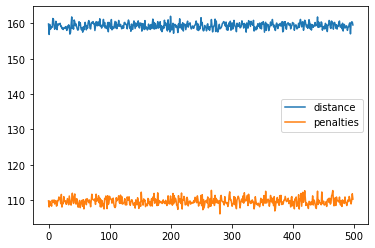

In [142]:
df = pd.DataFrame.from_dict(result_dict, orient='index').rename(columns={0:'distance', 1:'penalties'})
df.plot()

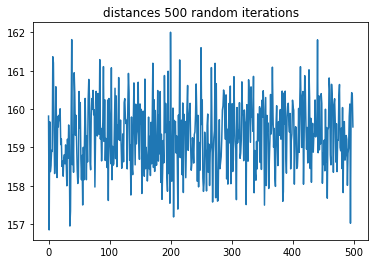

In [169]:
plotje = df['distance'].plot(title='distances 500 random iterations')
plotje.figure.savefig('500_random_distances.png')

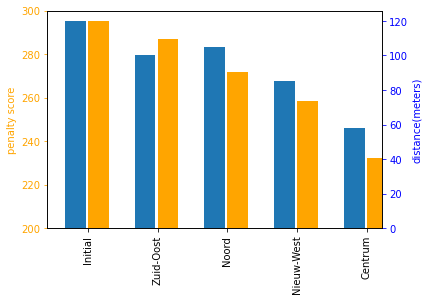

In [310]:
score = [295.12, 286.96, 271.81, 258.44, 232.12]
distances = [120, 100, 105, 85, 58]
phase = ['Initial', 'Zuid-Oost', 'Noord', 'Nieuw-West', 'Centrum']
df2 = pd.DataFrame(score, phase).rename(columns={0:'Penalty score'})
df2['distance'] = distances
plotje = df2['Penalty score'].plot(kind='bar', ylim=[200,300], width=0.3, color='orange', position=0)
plotje.set_ylabel('penalty score', color='orange')
plotje.tick_params(axis='y', colors='orange')
plotje = df2['distance'].plot(kind='bar', secondary_y=True, position=1.1, width=0.3)
plotje.set_ylabel('distance(meters)', color='blue')
plotje.tick_params(axis='y', colors='blue')

plotje.figure.savefig('subcluster_optimization_bar.png')

In [293]:
plotje = plt.figure()

<Figure size 432x288 with 0 Axes>